In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
corr_l = pd.read_csv("../results/correlation_l.csv")
results_o = pd.read_table("../results/offensive_results_w.tsv")
results_p = pd.read_table("../results/polite_results_w.tsv")

In [3]:
sns.set_palette("Set2")
sns.set_theme(style="whitegrid", font_scale=1.5)

In [26]:
print(sns.color_palette("muted").as_hex())

['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']


# Distributions of Scores

In [94]:
label_o = pd.melt(results_o.loc[:, 'label':'asian_score'], var_name='group', value_name='score')
label_o['dimension'] = 'Offensiveness'
label_p = pd.melt(results_p.loc[:, 'label':'asian_score'], var_name='group', value_name='score')
label_p['dimension'] = 'Politeness'
labels  = pd.concat([label_o, label_p], ignore_index=True)

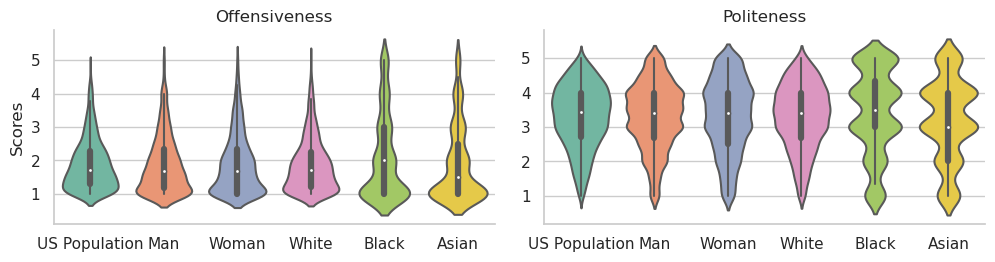

In [97]:
p1 = sns.catplot(data=labels, x='group', y='score', col='dimension', kind='violin',
                 height=3, aspect=1.7, sharey=False)
p1.set_axis_labels("", "Scores")
p1.set_xticklabels(["US Population", "Man", "Woman", "White", "Black", "Asian"])
p1.set_titles("{col_name}")

In [98]:
p1.savefig("plots/plot_v1_score_dist.pdf", format='pdf')

# Tendency Patterns, with different models

In [5]:
corr_l = corr_l.loc[corr_l['model']!='llama2']

In [6]:
corr_l['label'] = corr_l['label'].apply(lambda x: x.capitalize())
corr_l['label'] = corr_l['label'].apply(lambda x: re.sub("Overall", "US Population", x))
model_offensive = corr_l[(corr_l['dimension']=='offensiveness') & (corr_l['prefix']=='base')]
model_polite = corr_l[(corr_l['dimension']=='politeness') & (corr_l['prefix']=='base')]

options = ['US Population', 'White', 'Black', 'Asian']
model_offensive_ethnicity = model_offensive.loc[model_offensive['label'].isin(options)]
model_polite_ethnicity = model_polite.loc[model_polite['label'].isin(options)]

options = ['US Population', 'Man', 'Woman']
model_offensive_gender = model_offensive.loc[model_offensive['label'].isin(options)]
model_polite_gender = model_polite.loc[model_polite['label'].isin(options)]

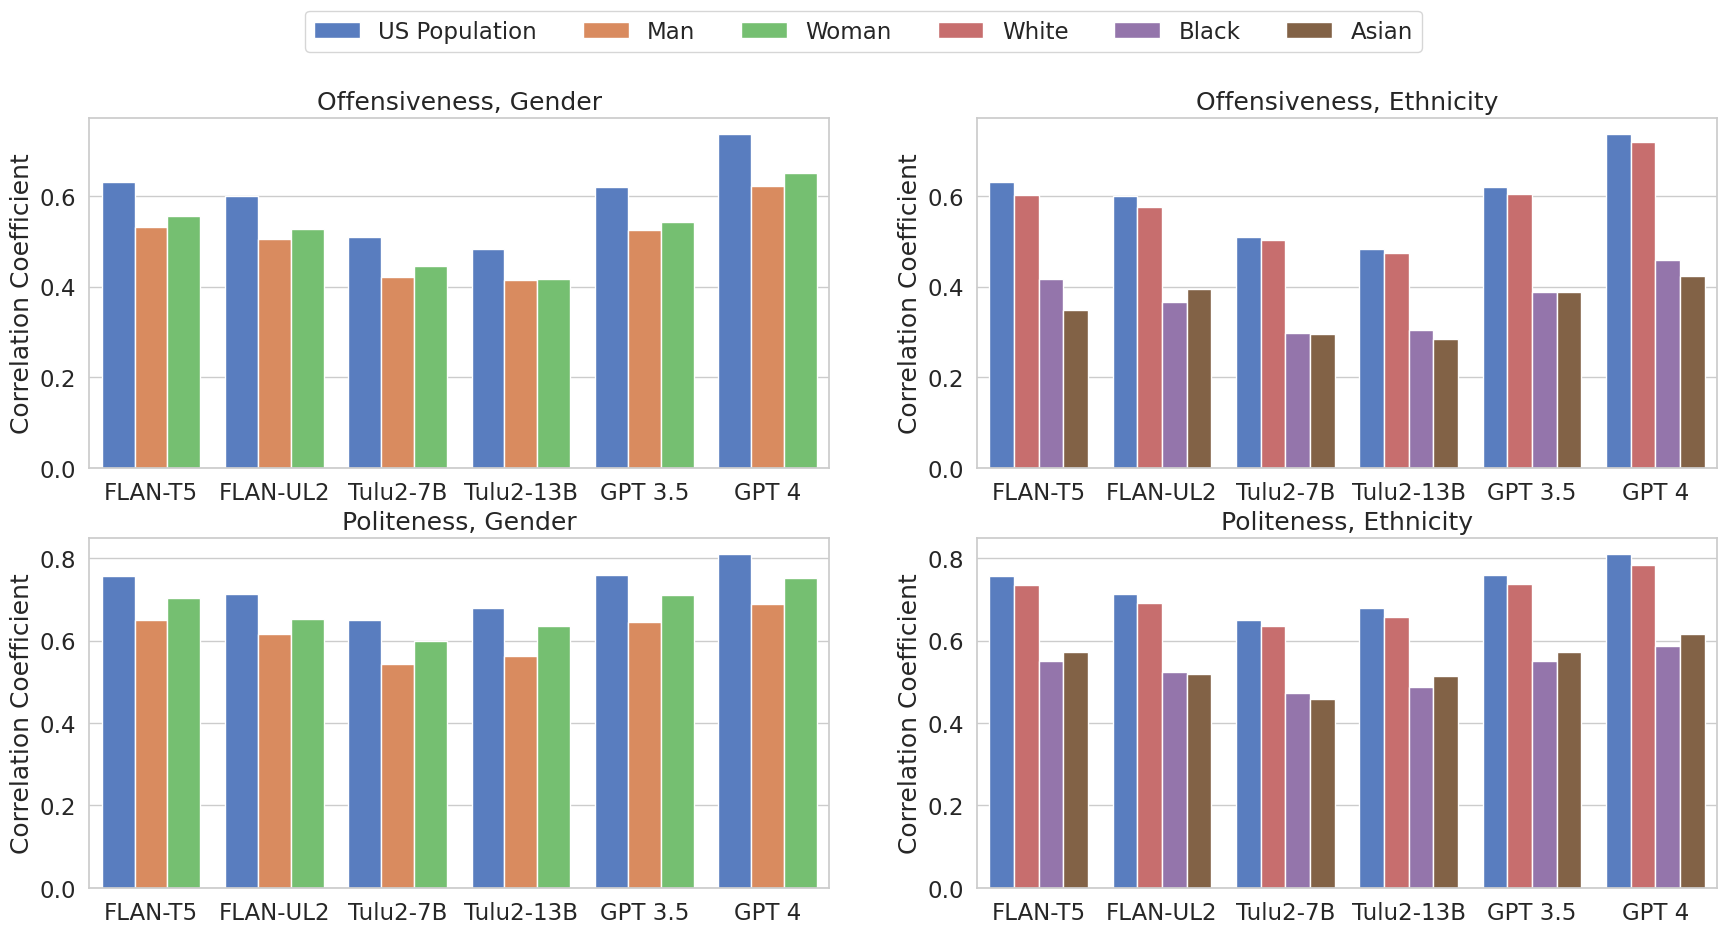

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(21, 10))

col1 = ['#4878d0', '#ee854a', '#6acc64', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']
col2 = ['#4878d0', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']

(sns.barplot(data=model_offensive_gender,
            x='model', y='correlation', hue='label',
            palette=col1, ax=axes[0, 0])
.set(title="Offensiveness, Gender", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=model_offensive_ethnicity,
            x='model', y='correlation', hue='label',
            palette=col2, ax=axes[0, 1])
.set(title="Offensiveness, Ethnicity", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=model_polite_gender,
            x='model', y='correlation', hue='label',
            palette=col1, ax=axes[1, 0])
.set(title="Politeness, Gender", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=model_polite_ethnicity,
            x='model', y='correlation', hue='label',
            palette=col2, ax=axes[1, 1])
.set(title="Politeness, Ethnicity", xlabel="", ylabel="Correlation Coefficient"))

for ax in axes.flat:
    ax.set_xticklabels(labels=["FLAN-T5", "FLAN-UL2", "Tulu2-7B", "Tulu2-13B", "GPT 3.5", "GPT 4"])
    ax.get_legend().remove()

handles1, labels1 = axes[0,0].get_legend_handles_labels()
handles2, labels2 = axes[0,1].get_legend_handles_labels()
labels = ['US Population', 'Man', 'Woman', 'White', 'Black', 'Asian']
fig.legend(handles1+handles2[1:], labels, loc='upper center', ncol=6)

plt.savefig("plots/plot_v1_base.pdf", format='pdf')

# Gap after adding identity prompt

In [10]:
corr_l = pd.read_csv("../results/correlation_l.csv")

dimensions = corr_l['dimension'].unique()
models = corr_l['model'].unique()
prefixes = corr_l['prefix'].unique()
labels = corr_l['label'].unique()

idx = 0
gaps = {}

for i in dimensions:
    corr_d = corr_l[corr_l['dimension']==i]
    for j in models:
        corr_m = corr_d[corr_d['model']==j]
        for k in range(len(prefixes)):
             if k==0:
                 continue
             pre = (corr_m[(corr_m['prefix']=='base')&(corr_m['label']==labels[k])]
                    .reset_index().loc[0, 'correlation'])
             post = (corr_m[(corr_m['prefix']==prefixes[k])&(corr_m['label']==labels[k])]
                     .reset_index().loc[0, 'correlation'])
             gaps[idx] = [i, j, prefixes[k], labels[k], pre, 'pre']
             gaps[idx+1] = [i, j, prefixes[k], labels[k], post, 'post']
             idx += 2

gap = pd.DataFrame.from_dict(gaps, orient='index', columns=['dimension', 'model', 'prefix', 'label', 'corr', 'pre-post'])

In [11]:
gap['label'] = gap['label'].apply(lambda x: x.capitalize())
gap_offensive = gap[(gap['dimension']=='offensiveness')]
gap_polite = gap[(gap['dimension']=='politeness')]

options = ['White', 'Black', 'Asian']
gap_offensive_ethnicity = gap_offensive.loc[gap_offensive['label'].isin(options)]
gap_polite_ethnicity = gap_polite.loc[gap_polite['label'].isin(options)]

options = ['Man', 'Woman']
gap_offensive_gender = gap_offensive.loc[gap_offensive['label'].isin(options)]
gap_polite_gender = gap_polite.loc[gap_polite['label'].isin(options)]

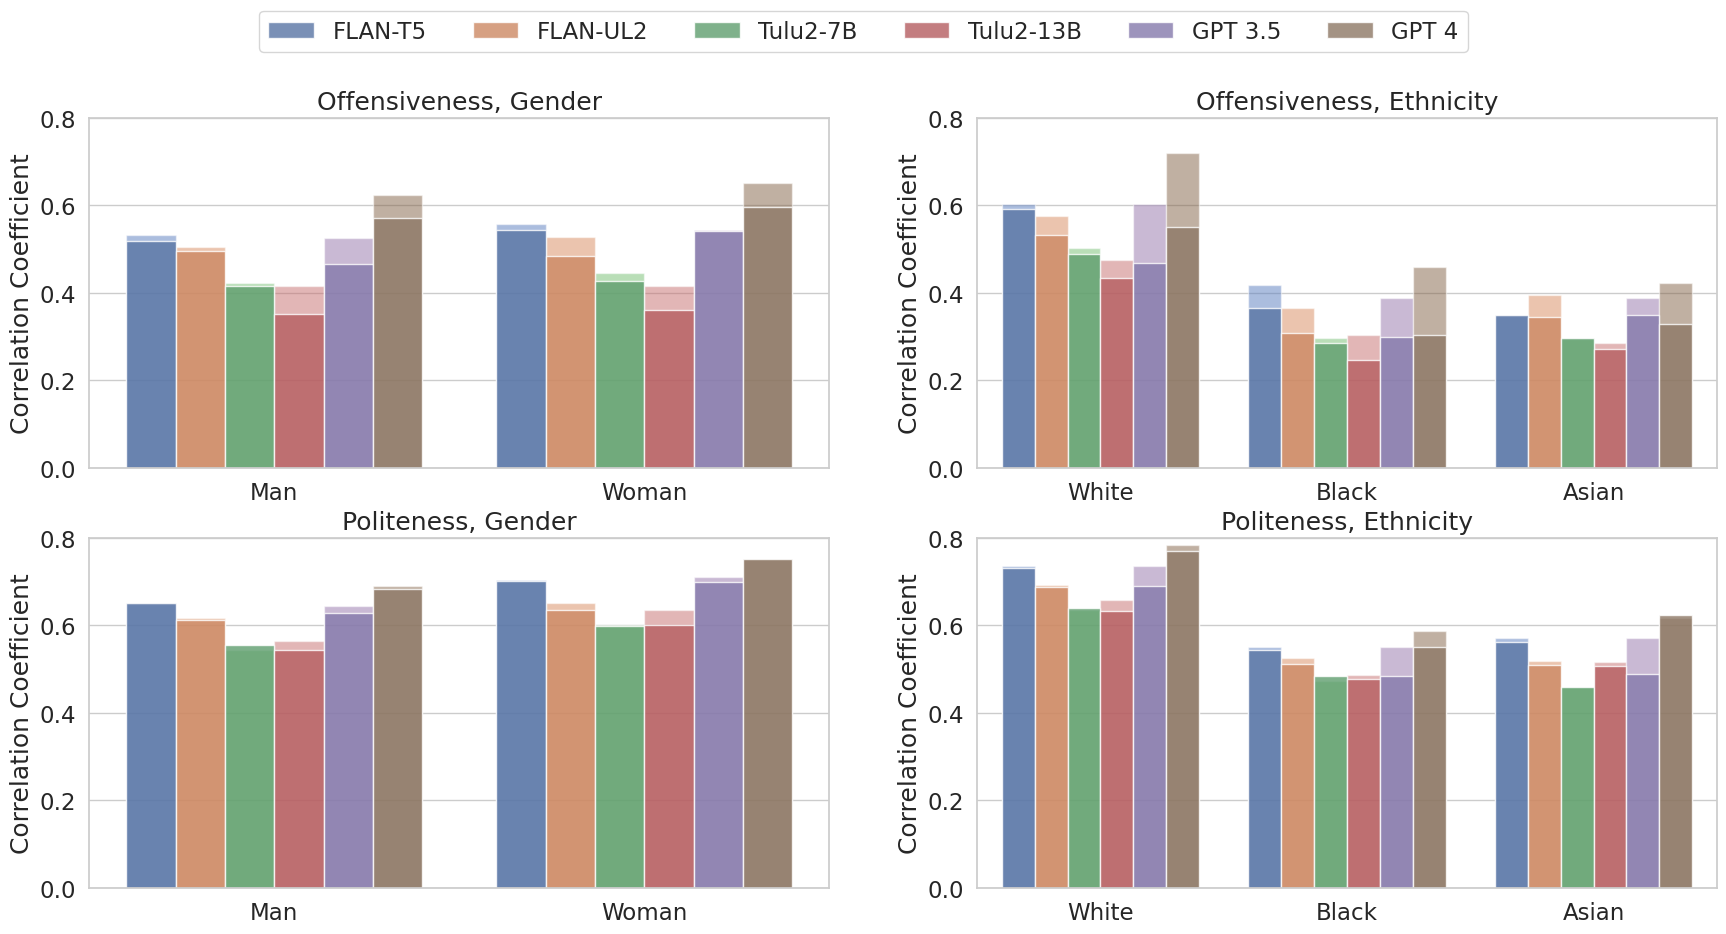

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(21, 10))

(sns.barplot(data=gap_offensive_gender[(gap_offensive_gender['pre-post']=='pre')],
            x='label', y='corr', hue='model',
            palette="muted", alpha=0.5, ax=axes[0,0]))
(sns.barplot(data=gap_offensive_gender[(gap_offensive_gender['pre-post']=='post')],
            x='label', y='corr', hue='model',
            palette="deep", alpha=0.8, ax=axes[0,0])
.set(title="Offensiveness, Gender", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=gap_offensive_ethnicity[(gap_offensive_ethnicity['pre-post']=='pre')],
            x='label', y='corr', hue='model',
            palette="muted", alpha=0.5, ax=axes[0,1]))
(sns.barplot(data=gap_offensive_ethnicity[(gap_offensive_ethnicity['pre-post']=='post')],
            x='label', y='corr', hue='model',
            palette="deep", alpha=0.8, ax=axes[0,1])
.set(title="Offensiveness, Ethnicity", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=gap_polite_gender[(gap_polite_gender['pre-post']=='pre')],
            x='label', y='corr', hue='model',
            palette="muted", alpha=0.5, ax=axes[1,0]))
(sns.barplot(data=gap_polite_gender[(gap_polite_gender['pre-post']=='post')],
            x='label', y='corr', hue='model',
            palette="deep", alpha=0.8, ax=axes[1,0])
.set(title="Politeness, Gender", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=gap_polite_ethnicity[(gap_polite_ethnicity['pre-post']=='pre')],
            x='label', y='corr', hue='model',
            palette="muted", alpha=0.5, ax=axes[1,1]))
(sns.barplot(data=gap_polite_ethnicity[(gap_polite_ethnicity['pre-post']=='post')],
            x='label', y='corr', hue='model',
            palette="deep", alpha=0.8, ax=axes[1,1])
.set(title="Politeness, Ethnicity", xlabel="", ylabel="Correlation Coefficient"))

for ax in axes.flat:
    ax.set_ylim(0, 0.8)
    ax.get_legend().remove()

handles, labels = axes[0,0].get_legend_handles_labels()
handles = handles[6:]
labels = ['FLAN-T5', 'FLAN-UL2', "Tulu2-7B", "Tulu2-13B", 'GPT 3.5', 'GPT 4']
fig.legend(handles, labels, loc='upper center', ncol=6)

plt.savefig("plots/plot_v1_gap.pdf", format='pdf')



# Robustness Check

In [4]:
corr_robust = pd.read_csv("../results/corr_robust_l.csv")
corr_robust_o = corr_robust[corr_robust['dimension']=='offensiveness']
corr_robust_p = corr_robust[corr_robust['dimension']=='politeness']

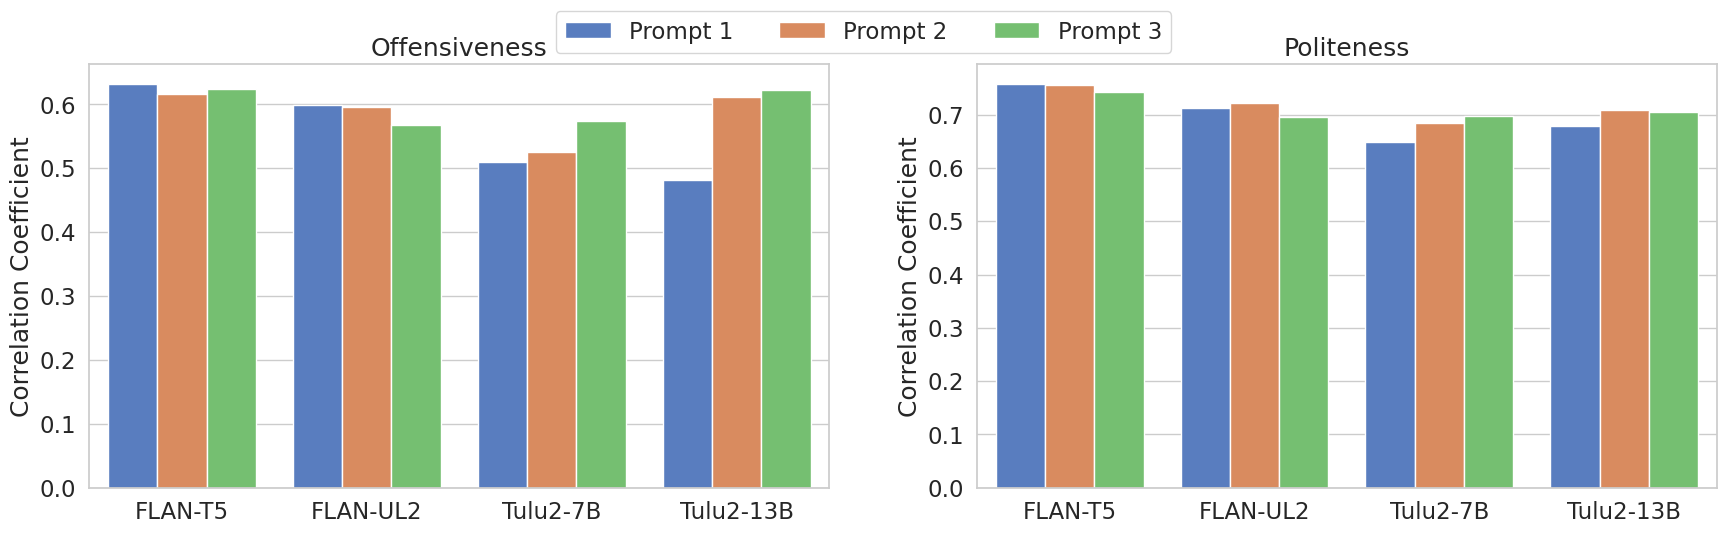

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(21, 5.5))

col1 = ['#4878d0', '#ee854a', '#6acc64', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']

(sns.barplot(data=corr_robust_o,
            x='model', y='corr', hue='prompt',
            palette=col1, ax=axes[0])
.set(title="Offensiveness", xlabel="", ylabel="Correlation Coefficient"))

(sns.barplot(data=corr_robust_p,
            x='model', y='corr', hue='prompt',
            palette=col1, ax=axes[1])
.set(title="Politeness", xlabel="", ylabel="Correlation Coefficient"))

for ax in axes:
    ax.set_xticklabels(labels=["FLAN-T5", "FLAN-UL2", "Tulu2-7B", "Tulu2-13B"])
    ax.get_legend().remove()

handles1, labels1 = axes[0].get_legend_handles_labels()
labels = ['Prompt 1', 'Prompt 2', 'Prompt 3']
fig.legend(handles1, labels, loc='upper center', ncol=3)

plt.savefig("../results/plot_v1_robust.pdf", format='pdf')